# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [1]:
import numpy as np
# import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Parameters

In [2]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**12            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

full_train = False           # 'True' enable all data set to train
test_train_data = False
train_proportion = 9 / 10.0  
d_train_num = int(train_proportion * 2**k)
d_test_num = 2**k - d_train_num



train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# Define NN model

In [3]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
#     return K.sum(K.not_equal(y_true, K.round(y_pred)))
#     return tf.reduce_mean(K.cast(K.equal(y_true, K.round(y_pred)),dtype = 'float32'))
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),dtype = 'int32'))

In [4]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# Define LLR
llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
llr = compose_model(llr_layers)
llr.compile(optimizer=optimizer, loss=loss)

# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# Define model
if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
else:
    model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

# Data Generation

In [5]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [6]:
# Create all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])
    
d_train = np.zeros((d_train_num,k),dtype=bool)
d_test2 = np.zeros((d_test_num,k),dtype=bool)
if full_train == False:
    temp = np.zeros(2**k,dtype=int)
    for i in range(0,2**k):
        temp[i] = i
    random.shuffle(temp)
    for i in range(0,d_train_num):
        d_train[i] = d[temp[i]]
    for i in range(d_train_num,d_train_num+d_test_num):
        d_test2[i - d_train_num] = d[temp[i]]
    d = d_train
# print(d_train)
# print(d_test2)
    
if full_train == True:
    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
else:
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((d_train_num, N),dtype=bool)
        u = np.zeros((d_train_num, N),dtype=bool)
        u[:,A] = d_train

        for i in range(0,d_train_num):
            x[i] = polar_transform_iter(u[i])

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(d_train_num,N), dtype=bool)

# Train Neural Network

In [7]:
model.summary()
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=1, shuffle=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modulator (Lambda)          (None, 16)                0         
                                                                 
 noise (Lambda)              (None, 16)                0         
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 12,776
Trainable params: 12,776
Non-trai

1/1 [==============================] - 0s 7ms/step - loss: 0.1541 - ber: 0.2609
Epoch 162/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1492 - ber: 0.2478
Epoch 163/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1520 - ber: 0.2549
Epoch 164/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1559 - ber: 0.2424
Epoch 165/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1567 - ber: 0.2690
Epoch 166/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1565 - ber: 0.2554
Epoch 167/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1547 - ber: 0.2582
Epoch 168/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1534 - ber: 0.2538
Epoch 169/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1497 - ber: 0.2462
Epoch 170/4096
1/1 [==============================] - 0s 14ms/step - loss: 0.1526 - ber: 0.2533
Epoch 171/4096
1/1 [==============================] - 0s 11ms/st

1/1 [==============================] - 0s 7ms/step - loss: 0.1541 - ber: 0.2451
Epoch 334/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1364 - ber: 0.2201
Epoch 335/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1461 - ber: 0.2332
Epoch 336/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1464 - ber: 0.2582
Epoch 337/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1464 - ber: 0.2511
Epoch 338/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1430 - ber: 0.2359
Epoch 339/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1455 - ber: 0.2435
Epoch 340/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1400 - ber: 0.2277
Epoch 341/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1351 - ber: 0.2163
Epoch 342/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1429 - ber: 0.2315
Epoch 343/4096
1/1 [==============================] - 0s 6ms/ste

1/1 [==============================] - 0s 7ms/step - loss: 0.1382 - ber: 0.2141
Epoch 506/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1347 - ber: 0.2168
Epoch 507/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1321 - ber: 0.2103
Epoch 508/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1305 - ber: 0.2054
Epoch 509/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1422 - ber: 0.2310
Epoch 510/4096
1/1 [==============================] - 0s 13ms/step - loss: 0.1346 - ber: 0.2125
Epoch 511/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1348 - ber: 0.2114
Epoch 512/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1381 - ber: 0.2185
Epoch 513/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1332 - ber: 0.2076
Epoch 514/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1346 - ber: 0.2261
Epoch 515/4096
1/1 [==============================] - 0s 8ms/ste

1/1 [==============================] - 0s 9ms/step - loss: 0.1298 - ber: 0.2082
Epoch 678/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1341 - ber: 0.2082
Epoch 679/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1273 - ber: 0.1946
Epoch 680/4096
1/1 [==============================] - 0s 16ms/step - loss: 0.1439 - ber: 0.2293
Epoch 681/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1275 - ber: 0.1995
Epoch 682/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1313 - ber: 0.2109
Epoch 683/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1410 - ber: 0.2321
Epoch 684/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1297 - ber: 0.2033
Epoch 685/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1316 - ber: 0.2022
Epoch 686/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1304 - ber: 0.1918
Epoch 687/4096
1/1 [==============================] - 0s 6ms/s

1/1 [==============================] - 0s 7ms/step - loss: 0.1239 - ber: 0.1815
Epoch 850/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1293 - ber: 0.2022
Epoch 851/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1274 - ber: 0.1951
Epoch 852/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1175 - ber: 0.1837
Epoch 853/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1332 - ber: 0.2120
Epoch 854/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1283 - ber: 0.1929
Epoch 855/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1303 - ber: 0.1978
Epoch 856/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1239 - ber: 0.1962
Epoch 857/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1296 - ber: 0.2049
Epoch 858/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1273 - ber: 0.1853
Epoch 859/4096
1/1 [==============================] - 0s 6ms/ste

1/1 [==============================] - 0s 6ms/step - loss: 0.1259 - ber: 0.1918
Epoch 1022/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1347 - ber: 0.2038
Epoch 1023/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1243 - ber: 0.1870
Epoch 1024/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1266 - ber: 0.1929
Epoch 1025/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1179 - ber: 0.1750
Epoch 1026/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1284 - ber: 0.1989
Epoch 1027/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1229 - ber: 0.1924
Epoch 1028/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1329 - ber: 0.1946
Epoch 1029/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1175 - ber: 0.1745
Epoch 1030/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1296 - ber: 0.1946
Epoch 1031/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.1096 - ber: 0.1625
Epoch 1192/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1236 - ber: 0.1821
Epoch 1193/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1262 - ber: 0.1853
Epoch 1194/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1236 - ber: 0.1897
Epoch 1195/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1205 - ber: 0.1788
Epoch 1196/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1195 - ber: 0.1832
Epoch 1197/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1212 - ber: 0.1815
Epoch 1198/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1243 - ber: 0.1826
Epoch 1199/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1169 - ber: 0.1739
Epoch 1200/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1203 - ber: 0.1837
Epoch 1201/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 7ms/step - loss: 0.1101 - ber: 0.1614
Epoch 1362/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1040 - ber: 0.1500
Epoch 1363/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1114 - ber: 0.1652
Epoch 1364/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1189 - ber: 0.1712
Epoch 1365/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1229 - ber: 0.1848
Epoch 1366/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1200 - ber: 0.1734
Epoch 1367/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1122 - ber: 0.1647
Epoch 1368/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1095 - ber: 0.1598
Epoch 1369/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1213 - ber: 0.1837
Epoch 1370/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1148 - ber: 0.1755
Epoch 1371/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.1002 - ber: 0.1418
Epoch 1532/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1084 - ber: 0.1571
Epoch 1533/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1067 - ber: 0.1522
Epoch 1534/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1166 - ber: 0.1755
Epoch 1535/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1054 - ber: 0.1451
Epoch 1536/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1138 - ber: 0.1668
Epoch 1537/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1220 - ber: 0.1815
Epoch 1538/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1100 - ber: 0.1516
Epoch 1539/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1298 - ber: 0.1918
Epoch 1540/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1060 - ber: 0.1495
Epoch 1541/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1119 - ber: 0.1620
Epoch 1702/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1044 - ber: 0.1571
Epoch 1703/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1072 - ber: 0.1533
Epoch 1704/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1033 - ber: 0.1429
Epoch 1705/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0989 - ber: 0.1375
Epoch 1706/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1107 - ber: 0.1647
Epoch 1707/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1028 - ber: 0.1424
Epoch 1708/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1063 - ber: 0.1500
Epoch 1709/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0991 - ber: 0.1413
Epoch 1710/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1052 - ber: 0.1484
Epoch 1711/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0962 - ber: 0.1429
Epoch 1872/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1161 - ber: 0.1609
Epoch 1873/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1171 - ber: 0.1690
Epoch 1874/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0944 - ber: 0.1283
Epoch 1875/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0964 - ber: 0.1364
Epoch 1876/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1049 - ber: 0.1549
Epoch 1877/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1100 - ber: 0.1538
Epoch 1878/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0928 - ber: 0.1413
Epoch 1879/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0970 - ber: 0.1380
Epoch 1880/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0986 - ber: 0.1418
Epoch 1881/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1027 - ber: 0.1522
Epoch 2042/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0979 - ber: 0.1408
Epoch 2043/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1075 - ber: 0.1478
Epoch 2044/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1024 - ber: 0.1418
Epoch 2045/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1008 - ber: 0.1418
Epoch 2046/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1005 - ber: 0.1418
Epoch 2047/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0881 - ber: 0.1223
Epoch 2048/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0859 - ber: 0.1130
Epoch 2049/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0982 - ber: 0.1402
Epoch 2050/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1062 - ber: 0.1527
Epoch 2051/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0961 - ber: 0.1364
Epoch 2212/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1068 - ber: 0.1538
Epoch 2213/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0965 - ber: 0.1321
Epoch 2214/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1002 - ber: 0.1446
Epoch 2215/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1012 - ber: 0.1457
Epoch 2216/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1050 - ber: 0.1511
Epoch 2217/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0998 - ber: 0.1386
Epoch 2218/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0875 - ber: 0.1212
Epoch 2219/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1008 - ber: 0.1495
Epoch 2220/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0935 - ber: 0.1364
Epoch 2221/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0875 - ber: 0.1250
Epoch 2382/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0968 - ber: 0.1402
Epoch 2383/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0896 - ber: 0.1239
Epoch 2384/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0893 - ber: 0.1228
Epoch 2385/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1038 - ber: 0.1478
Epoch 2386/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1008 - ber: 0.1429
Epoch 2387/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0920 - ber: 0.1375
Epoch 2388/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0948 - ber: 0.1359
Epoch 2389/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0900 - ber: 0.1304
Epoch 2390/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0964 - ber: 0.1386
Epoch 2391/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0956 - ber: 0.1364
Epoch 2552/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0865 - ber: 0.1228
Epoch 2553/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1034 - ber: 0.1495
Epoch 2554/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1053 - ber: 0.1538
Epoch 2555/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0987 - ber: 0.1337
Epoch 2556/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0869 - ber: 0.1223
Epoch 2557/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1043 - ber: 0.1478
Epoch 2558/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0948 - ber: 0.1321
Epoch 2559/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1016 - ber: 0.1413
Epoch 2560/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0906 - ber: 0.1277
Epoch 2561/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0967 - ber: 0.1386
Epoch 2722/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1003 - ber: 0.1348
Epoch 2723/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0900 - ber: 0.1261
Epoch 2724/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0860 - ber: 0.1196
Epoch 2725/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0977 - ber: 0.1337
Epoch 2726/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0885 - ber: 0.1277
Epoch 2727/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0752 - ber: 0.1054
Epoch 2728/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0851 - ber: 0.1212
Epoch 2729/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0863 - ber: 0.1217
Epoch 2730/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0923 - ber: 0.1277
Epoch 2731/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0945 - ber: 0.1386
Epoch 2892/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0967 - ber: 0.1408
Epoch 2893/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0885 - ber: 0.1245
Epoch 2894/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0835 - ber: 0.1174
Epoch 2895/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0918 - ber: 0.1272
Epoch 2896/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0818 - ber: 0.1120
Epoch 2897/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0971 - ber: 0.1418
Epoch 2898/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0946 - ber: 0.1342
Epoch 2899/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0886 - ber: 0.1245
Epoch 2900/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0870 - ber: 0.1261
Epoch 2901/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0987 - ber: 0.1413
Epoch 3062/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0949 - ber: 0.1288
Epoch 3063/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0752 - ber: 0.1049
Epoch 3064/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0765 - ber: 0.1049
Epoch 3065/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0930 - ber: 0.1315
Epoch 3066/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0985 - ber: 0.1462
Epoch 3067/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0884 - ber: 0.1277
Epoch 3068/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0921 - ber: 0.1293
Epoch 3069/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0823 - ber: 0.1114
Epoch 3070/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0840 - ber: 0.1158
Epoch 3071/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0887 - ber: 0.1234
Epoch 3232/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0864 - ber: 0.1185
Epoch 3233/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0795 - ber: 0.1141
Epoch 3234/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0874 - ber: 0.1239
Epoch 3235/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0863 - ber: 0.1185
Epoch 3236/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0945 - ber: 0.1266
Epoch 3237/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0880 - ber: 0.1147
Epoch 3238/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0880 - ber: 0.1212
Epoch 3239/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0889 - ber: 0.1217
Epoch 3240/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0877 - ber: 0.1185
Epoch 3241/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0999 - ber: 0.1462
Epoch 3402/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0811 - ber: 0.1092
Epoch 3403/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0862 - ber: 0.1261
Epoch 3404/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0817 - ber: 0.1054
Epoch 3405/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0862 - ber: 0.1152
Epoch 3406/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0892 - ber: 0.1223
Epoch 3407/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0852 - ber: 0.1120
Epoch 3408/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0839 - ber: 0.1196
Epoch 3409/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0903 - ber: 0.1288
Epoch 3410/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0813 - ber: 0.1196
Epoch 3411/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.1054 - ber: 0.1516
Epoch 3572/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0876 - ber: 0.1158
Epoch 3573/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0892 - ber: 0.1239
Epoch 3574/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0840 - ber: 0.1130
Epoch 3575/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0989 - ber: 0.1413
Epoch 3576/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0799 - ber: 0.1038
Epoch 3577/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.0804 - ber: 0.1141
Epoch 3578/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.0827 - ber: 0.1092
Epoch 3579/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0833 - ber: 0.1114
Epoch 3580/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0881 - ber: 0.1196
Epoch 3581/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0853 - ber: 0.1223
Epoch 3742/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0836 - ber: 0.1130
Epoch 3743/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0851 - ber: 0.1152
Epoch 3744/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0728 - ber: 0.0962
Epoch 3745/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0963 - ber: 0.1391
Epoch 3746/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0812 - ber: 0.1130
Epoch 3747/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0868 - ber: 0.1174
Epoch 3748/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0871 - ber: 0.1207
Epoch 3749/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0753 - ber: 0.1033
Epoch 3750/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0907 - ber: 0.1245
Epoch 3751/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0849 - ber: 0.1147
Epoch 3912/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0721 - ber: 0.0978
Epoch 3913/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0825 - ber: 0.1168
Epoch 3914/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0831 - ber: 0.1125
Epoch 3915/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0941 - ber: 0.1315
Epoch 3916/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0906 - ber: 0.1293
Epoch 3917/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0775 - ber: 0.1109
Epoch 3918/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0750 - ber: 0.0995
Epoch 3919/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0863 - ber: 0.1245
Epoch 3920/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0859 - ber: 0.1261
Epoch 3921/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0892 - ber: 0.1217
Epoch 4082/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0759 - ber: 0.1033
Epoch 4083/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0798 - ber: 0.1114
Epoch 4084/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0928 - ber: 0.1310
Epoch 4085/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0768 - ber: 0.1000
Epoch 4086/4096
1/1 [==============================] - 0s 13ms/step - loss: 0.0864 - ber: 0.1245
Epoch 4087/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0864 - ber: 0.1179
Epoch 4088/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0684 - ber: 0.0875
Epoch 4089/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0779 - ber: 0.1196
Epoch 4090/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0908 - ber: 0.1272
Epoch 4091/4096
1/1 [==============================] - 

# Test NN

In [8]:
test_batch = 1000  
# num_words = 100000      # multiple of test_batch
num_words = 1000

# multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

In [9]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

print(d_test_num)
for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        if full_train == True:
            d_test = np.random.randint(0,2,size=(test_batch,k)) 
        else:
            d_test = np.zeros((test_batch,k),dtype=bool)
            for j in range(0, test_batch):
#                 d_test[j] = d_test2[np.random.randint(0,d_test_num)]
                if test_train_data == True:
                    d_test[j] = d_train[np.random.randint(0,d_test_num)]
                else:
                    d_test[j] = d_test2[np.random.randint(0,d_test_num)]
            

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
        nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=1)[1]
        nb_bits[i] += d_test.size

26
1/1 [==============================] - 0s 25ms/step - loss: 0.0585 - errors: 585.0000


# Load MAP

In [10]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

# Plot Bit-Error-Rate

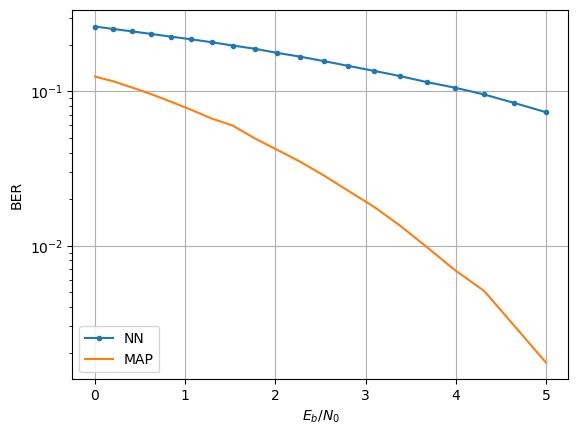

In [11]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits, '.-')
legend.append('NN') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map,)
legend.append('MAP') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()

In [12]:
# save data

